In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import xgboost as xgb
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [3]:
# ============ STEP 1: LOAD AND PREPARE DATA ============
print("Loading dataset...")
df = pd.read_csv(r'C:\Users\TPWODL\New folder_Content\TimeSeriesForecasting_End_To_End\data\raw\electricity demand dataset.csv')  # Replace with your file path

# Create datetime index - Adjust based on your timestamp column
df['Timestamp'] = pd.to_datetime(df['Timestamp'])  # If you have timestamp column
# Or create from the date columns you have:
# df['Timestamp'] = pd.date_range(start='2020-01-01', periods=len(df), freq='H')
df.dropna(inplace=True)
df = df.sort_values('Timestamp').reset_index(drop=True)
df.set_index('Timestamp', inplace=True)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(df.head())

# Extract target variable (Energy Demand)
ts_data = df['Demand'].values.astype(float)
print(f"\nTime series shape: {ts_data.shape}")
print(f"Missing values: {pd.isna(ts_data).sum()}")

Loading dataset...
Dataset shape: (43817, 8)
Date range: 2020-01-01 00:00:00 to 2024-12-31 00:00:00
            hour  dayofweek  month    year  dayofyear  Temperature   Humidity  \
Timestamp                                                                       
2020-01-01   0.0        2.0    1.0  2020.0        1.0     3.000000  61.288951   
2020-01-01  23.0        2.0    1.0  2020.0        1.0     3.000000  51.487121   
2020-01-01  22.0        2.0    1.0  2020.0        1.0     3.000000  56.571654   
2020-01-01  21.0        2.0    1.0  2020.0        1.0     3.000000  59.666195   
2020-01-01  20.0        2.0    1.0  2020.0        1.0     3.835712  44.737649   

                 Demand  
Timestamp                
2020-01-01  2457.119872  
2020-01-01  2622.193016  
2020-01-01  3213.228194  
2020-01-01  3890.171574  
2020-01-01  4424.292539  

Time series shape: (43817,)
Missing values: 0


In [6]:
df

,hour,dayofweek,month,year,dayofyear,Temperature,Humidity,Demand
Timestamp,,,,,,,,
2020-01-01,0.0,2.0,1.0,2020.0,1.0,3.000000,61.288951,2457.119872
2020-01-01,23.0,2.0,1.0,2020.0,1.0,3.000000,51.487121,2622.193016
2020-01-01,22.0,2.0,1.0,2020.0,1.0,3.000000,56.571654,3213.228194
2020-01-01,21.0,2.0,1.0,2020.0,1.0,3.000000,59.666195,3890.171574
2020-01-01,20.0,2.0,1.0,2020.0,1.0,3.835712,44.737649,4424.292539
...,...,...,...,...,...,...,...,...
2024-12-31,2.0,1.0,12.0,2024.0,366.0,3.000000,55.076004,2431.538942
2024-12-31,1.0,1.0,12.0,2024.0,366.0,3.000000,79.536292,2654.477513
2024-12-31,0.0,1.0,12.0,2024.0,366.0,3.000000,74.124312,2722.480185


In [13]:
df.tail()

,hour,dayofweek,month,year,dayofyear,Temperature,Humidity,Demand
Timestamp,,,,,,,,
2024-12-31,2.0,1.0,12.0,2024.0,366.0,3.000000,55.076004,2431.538942
2024-12-31,1.0,1.0,12.0,2024.0,366.0,3.000000,79.536292,2654.477513
2024-12-31,0.0,1.0,12.0,2024.0,366.0,3.000000,74.124312,2722.480185
2024-12-31,10.0,1.0,12.0,2024.0,366.0,21.984042,77.277297,4813.689951
2024-12-31,23.0,1.0,12.0,2024.0,366.0,6.037472,59.931925,3219.023339


In [7]:
ts_data

array([2457.119872, 2622.193016, 3213.228194, ..., 2722.480185,
       4813.689951, 3219.023339], shape=(43817,))

In [11]:
ts_data.shape

(43817,)


--- TIME SERIES VISUALIZATION ---
✓ Time series plot saved as 'xgb_time_series_plot.png'


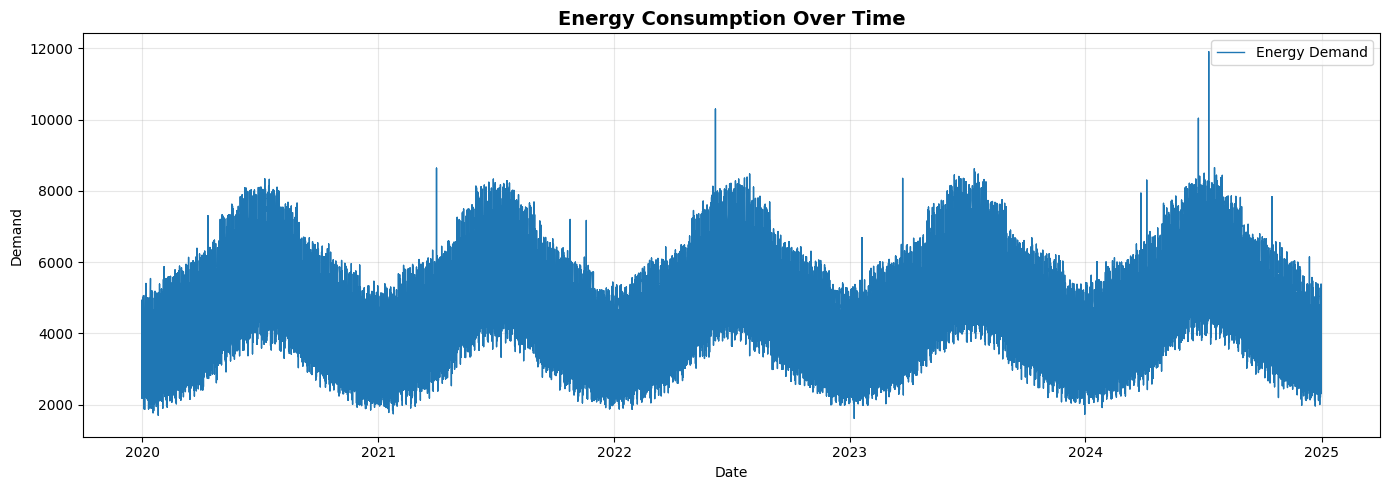

In [12]:
# ============ STEP 2: TIME SERIES VISUALIZATION ============
print("\n--- TIME SERIES VISUALIZATION ---")
plt.figure(figsize=(14, 5))
plt.plot(df.index, ts_data, label='Energy Demand', linewidth=1)
plt.title('Energy Consumption Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('xgb_time_series_plot.png', dpi=300)
print("✓ Time series plot saved as 'xgb_time_series_plot.png'")
plt.show()

In [14]:
# ============ STEP 3: FEATURE ENGINEERING ============
print("\n--- FEATURE ENGINEERING ---")

# Lookback window (past 24 hours to predict next hour)
lookback = 24

def create_features(data, lookback):
    """Create lag features and temporal features"""
    X = []
    y = []
    
    for i in range(lookback, len(data)):
        # Lag features (previous 24 hours)
        lag_features = data[i-lookback:i]
        
        # Statistical features from lag
        lag_mean = np.mean(lag_features)
        lag_std = np.std(lag_features)
        lag_min = np.min(lag_features)
        lag_max = np.max(lag_features)
        lag_median = np.median(lag_features)
        
        # Create feature vector
        features = list(lag_features) + [lag_mean, lag_std, lag_min, lag_max, lag_median]
        
        X.append(features)
        y.append(data[i])
    
    return np.array(X), np.array(y)

X, y = create_features(ts_data, lookback)
print(f"Features shape (X): {X.shape}")
print(f"Target shape (y): {y.shape}")
print(f"Number of features: {X.shape[1]}")
print("  - 24 lag features (previous 24 hours)")
print("  - 1 mean feature")
print("  - 1 std feature")
print("  - 1 min feature")
print("  - 1 max feature")
print("  - 1 median feature")


--- FEATURE ENGINEERING ---
Features shape (X): (43793, 29)
Target shape (y): (43793,)
Number of features: 29
  - 24 lag features (previous 24 hours)
  - 1 mean feature
  - 1 std feature
  - 1 min feature
  - 1 max feature
  - 1 median feature


In [15]:
X

array([[2457.119872 , 2622.193016 , 3213.228194 , ..., 2174.232413 ,
        4934.749367 , 4317.040594 ],
       [2622.193016 , 3213.228194 , 3890.171574 , ..., 2174.232413 ,
        4934.749367 , 4409.1394105],
       [3213.228194 , 3890.171574 , 4424.292539 , ..., 2174.232413 ,
        4934.749367 , 4409.1394105],
       ...,
       [2644.04597  , 2699.075526 , 4647.584931 , ..., 2309.34562  ,
        5381.239476 , 4498.8403335],
       [2699.075526 , 4647.584931 , 4736.218349 , ..., 2309.34562  ,
        5381.239476 , 4498.8403335],
       [4647.584931 , 4736.218349 , 4691.234998 , ..., 2309.34562  ,
        5381.239476 , 4544.6916215]], shape=(43793, 29))

In [16]:
y

array([4527.388062, 2862.462499, 3165.911593, ..., 2722.480185,
       4813.689951, 3219.023339], shape=(43793,))

In [17]:
# ============ STEP 4: DATA NORMALIZATION ============
print("\n--- DATA NORMALIZATION ---")

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

print(f"Features scaled: {X_scaled.shape}")
print(f"Target scaled: {y_scaled.shape}")
print("✓ Data normalized using MinMaxScaler")


--- DATA NORMALIZATION ---
Features scaled: (43793, 29)
Target scaled: (43793,)
✓ Data normalized using MinMaxScaler


In [18]:
# ============ STEP 5: TRAIN-TEST SPLIT ============
print("\n--- TRAIN-TEST SPLIT ---")

train_size = int(len(X_scaled) * 0.8)

X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

print(f"Training set: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Testing set: X_test {X_test.shape}, y_test {y_test.shape}")


--- TRAIN-TEST SPLIT ---
Training set: X_train (35034, 29), y_train (35034,)
Testing set: X_test (8759, 29), y_test (8759,)


In [20]:
# ============ STEP 6: BUILD AND TRAIN XGBOOST MODEL ============
print("\n--- BUILDING AND TRAINING XGBOOST MODEL ---")

# XGBoost parameters
xgb_params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_estimators': 200,
    'random_state': 42,
    'verbosity': 1
}

print("XGBoost Parameters:")
for key, value in xgb_params.items():
    print(f"  {key}: {value}")

print("\nTraining XGBoost model (this may take a minute)...\n")

xgb_model = xgb.XGBRegressor(**xgb_params)
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

print("\n✓ XGBoost model training completed!")


--- BUILDING AND TRAINING XGBOOST MODEL ---
XGBoost Parameters:
  objective: reg:squarederror
  max_depth: 6
  learning_rate: 0.1
  subsample: 0.8
  colsample_bytree: 0.8
  n_estimators: 200
  random_state: 42
  verbosity: 1

Training XGBoost model (this may take a minute)...

[0]	validation_0-rmse:0.12940
[1]	validation_0-rmse:0.12204
[2]	validation_0-rmse:0.11578
[3]	validation_0-rmse:0.11007
[4]	validation_0-rmse:0.10509
[5]	validation_0-rmse:0.10090
[6]	validation_0-rmse:0.09709
[7]	validation_0-rmse:0.09369
[8]	validation_0-rmse:0.09072
[9]	validation_0-rmse:0.08818
[10]	validation_0-rmse:0.08595
[11]	validation_0-rmse:0.08396
[12]	validation_0-rmse:0.08234
[13]	validation_0-rmse:0.08071
[14]	validation_0-rmse:0.07946
[15]	validation_0-rmse:0.07825
[16]	validation_0-rmse:0.07711
[17]	validation_0-rmse:0.07614
[18]	validation_0-rmse:0.07533
[19]	validation_0-rmse:0.07453
[20]	validation_0-rmse:0.07389
[21]	validation_0-rmse:0.07330
[22]	validation_0-rmse:0.07273
[23]	validation_0-


--- FEATURE IMPORTANCE ---

Top 10 Most Important Features:
    Feature  Importance
23  Lag_24h    0.289945
28   Median    0.157002
27      Max    0.116939
22  Lag_23h    0.056535
25      Std    0.045494
19  Lag_20h    0.035541
1    Lag_2h    0.022796
24     Mean    0.020934
0    Lag_1h    0.018458
20  Lag_21h    0.018329

✓ Feature importance plot saved as 'xgb_feature_importance.png'


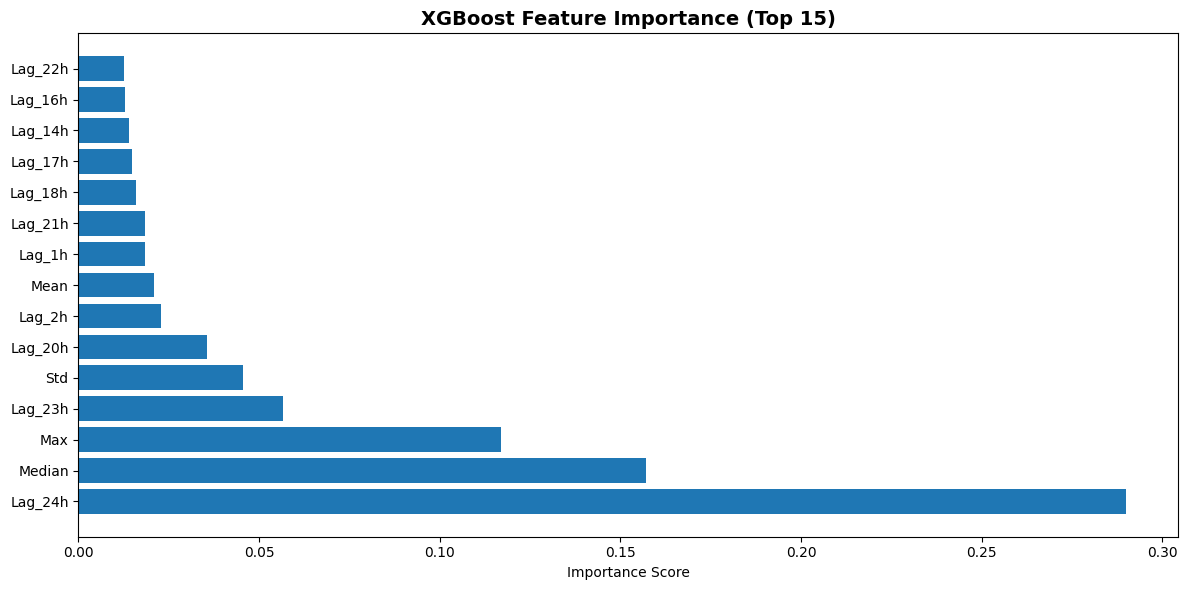

In [21]:
# ============ STEP 7: FEATURE IMPORTANCE ============
print("\n--- FEATURE IMPORTANCE ---")

# Get feature importance
feature_importance = xgb_model.feature_importances_
feature_names = [f'Lag_{i+1}h' for i in range(lookback)] + \
                ['Mean', 'Std', 'Min', 'Max', 'Median']

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10).to_string())

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'].head(15), importance_df['Importance'].head(15))
plt.title('XGBoost Feature Importance (Top 15)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.savefig('xgb_feature_importance.png', dpi=300)
print("\n✓ Feature importance plot saved as 'xgb_feature_importance.png'")
plt.show()

In [22]:
# ============ STEP 8: IN-SAMPLE PREDICTIONS ============
print("\n--- IN-SAMPLE PREDICTIONS ---")

y_train_pred_scaled = xgb_model.predict(X_train)
y_test_pred_scaled = xgb_model.predict(X_test)

# Inverse transform to original scale
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).ravel()
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).ravel()
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).ravel()

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
train_mae = mean_absolute_error(y_train_actual, y_train_pred)
train_r2 = r2_score(y_train_actual, y_train_pred)
train_mape = mean_absolute_percentage_error(y_train_actual, y_train_pred)

test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
test_mae = mean_absolute_error(y_test_actual, y_test_pred)
test_r2 = r2_score(y_test_actual, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test_actual, y_test_pred)

print("\nTraining Metrics:")
print(f"  RMSE:  {train_rmse:.4f}")
print(f"  MAE:   {train_mae:.4f}")
print(f"  MAPE:  {train_mape:.4f}%")
print(f"  R²:    {train_r2:.4f}")

print("\nTesting Metrics:")
print(f"  RMSE:  {test_rmse:.4f}")
print(f"  MAE:   {test_mae:.4f}")
print(f"  MAPE:  {test_mape:.4f}%")
print(f"  R²:    {test_r2:.4f}")



--- IN-SAMPLE PREDICTIONS ---

Training Metrics:
  RMSE:  454.9946
  MAE:   333.1678
  MAPE:  0.0758%
  R²:    0.8960

Testing Metrics:
  RMSE:  605.4162
  MAE:   437.1652
  MAPE:  0.0952%
  R²:    0.8165



--- VISUALIZATION: ACTUAL VS PREDICTED ---
✓ Actual vs Predicted plot saved as 'xgb_actual_vs_predicted.png'


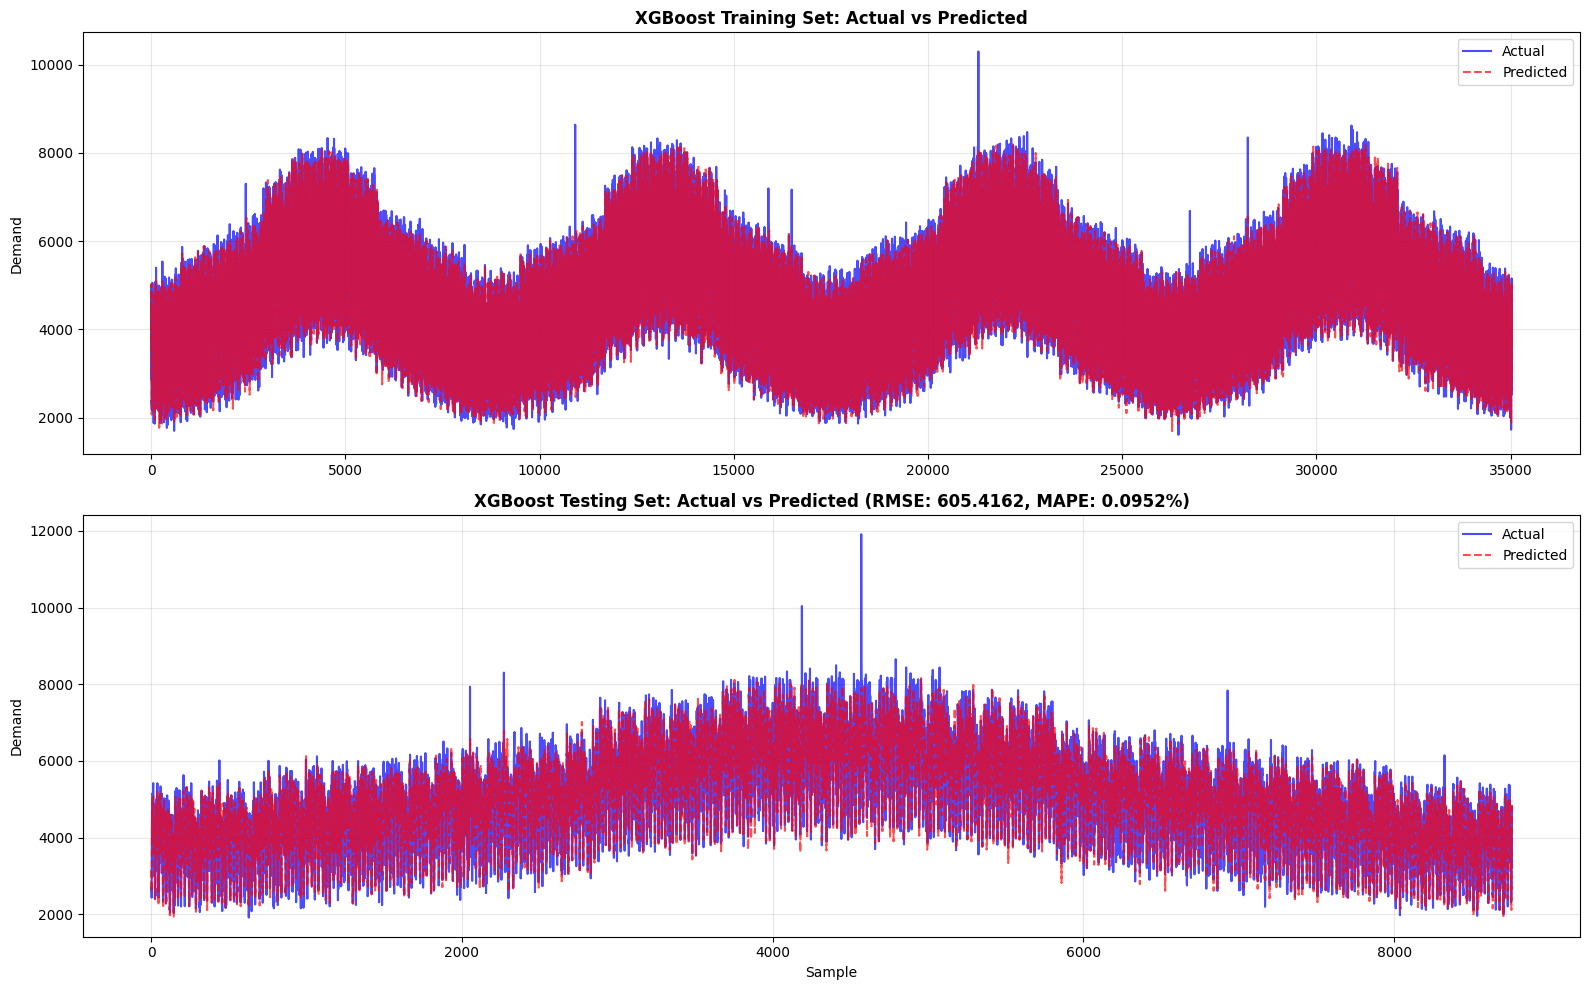

In [23]:
# ============ STEP 9: VISUALIZATION - ACTUAL VS PREDICTED ============
print("\n--- VISUALIZATION: ACTUAL VS PREDICTED ---")

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: Training predictions
ax1 = axes[0]
ax1.plot(y_train_actual, 'b-', label='Actual', linewidth=1.5, alpha=0.7)
ax1.plot(y_train_pred, 'r--', label='Predicted', linewidth=1.5, alpha=0.7)
ax1.set_title('XGBoost Training Set: Actual vs Predicted', fontsize=12, fontweight='bold')
ax1.set_ylabel('Demand')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Testing predictions
ax2 = axes[1]
ax2.plot(y_test_actual, 'b-', label='Actual', linewidth=1.5, alpha=0.7)
ax2.plot(y_test_pred, 'r--', label='Predicted', linewidth=1.5, alpha=0.7)
ax2.set_title(f'XGBoost Testing Set: Actual vs Predicted (RMSE: {test_rmse:.4f}, MAPE: {test_mape:.4f}%)', 
              fontsize=12, fontweight='bold')
ax2.set_xlabel('Sample')
ax2.set_ylabel('Demand')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('xgb_actual_vs_predicted.png', dpi=300)
print("✓ Actual vs Predicted plot saved as 'xgb_actual_vs_predicted.png'")
plt.show()


In [24]:
# ============ STEP 10: PREPARE DATA FOR 30-DAY FORECAST ============
print("\n--- PREPARING DATA FOR 30-DAY FORECAST ---")

forecast_steps = 30 * 24  # 30 days * 24 hours = 720 hours

# Use last lookback samples to start forecasting
last_data = ts_data[-lookback:].copy()
print(f"Last {lookback} hours data shape: {last_data.shape}")


--- PREPARING DATA FOR 30-DAY FORECAST ---
Last 24 hours data shape: (24,)


In [25]:
# ============ STEP 11: FORECAST NEXT 30 DAYS ============
print("\n--- FORECASTING NEXT 30 DAYS ---")
print(f"Generating {forecast_steps} hourly predictions (30 days)...\n")

forecast_predictions_original = []
current_data = last_data.copy()

for i in range(forecast_steps):
    # Create features from current data
    lag_mean = np.mean(current_data[-lookback:])
    lag_std = np.std(current_data[-lookback:])
    lag_min = np.min(current_data[-lookback:])
    lag_max = np.max(current_data[-lookback:])
    lag_median = np.median(current_data[-lookback:])
    
    features = np.concatenate([current_data[-lookback:], 
                               [lag_mean, lag_std, lag_min, lag_max, lag_median]]).reshape(1, -1)
    
    # Normalize features
    features_scaled = scaler_X.transform(features)
    
    # Predict next hour (scaled)
    next_pred_scaled = xgb_model.predict(features_scaled)[0]
    
    # Inverse transform to original scale
    next_pred_original = scaler_y.inverse_transform([[next_pred_scaled]])[0, 0]
    
    forecast_predictions_original.append(next_pred_original)
    
    # Update current data for next iteration
    current_data = np.append(current_data[1:], next_pred_original)
    
    if (i + 1) % 168 == 0:  # Print every week
        print(f"  Generated {i + 1}/{forecast_steps} predictions ({(i+1)/24:.1f} days)")

forecast_predictions_original = np.array(forecast_predictions_original)

print(f"\n✓ 30-Day forecast completed!")
print(f"Forecast shape: {forecast_predictions_original.shape}")



--- FORECASTING NEXT 30 DAYS ---
Generating 720 hourly predictions (30 days)...

  Generated 168/720 predictions (7.0 days)
  Generated 336/720 predictions (14.0 days)
  Generated 504/720 predictions (21.0 days)
  Generated 672/720 predictions (28.0 days)

✓ 30-Day forecast completed!
Forecast shape: (720,)


In [26]:
# ============ STEP 12: CREATE FORECAST DATAFRAME ============
print("\n--- CREATING FORECAST DATAFRAME ---")

# Generate future dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(hours=1), 
                              periods=forecast_steps, freq='H')

forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecast': forecast_predictions_original
})

print("\nForecast DataFrame (First 10 rows):")
print(forecast_df.head(10))

print("\nForecast DataFrame (Last 10 rows):")
print(forecast_df.tail(10))

# Save forecast to CSV
forecast_df.to_csv('energy_forecast_30days_xgboost.csv', index=False)
print("\n✓ Forecast saved to 'energy_forecast_30days_xgboost.csv'")


--- CREATING FORECAST DATAFRAME ---

Forecast DataFrame (First 10 rows):
                 Date     Forecast
0 2024-12-31 01:00:00  4631.945472
1 2024-12-31 02:00:00  4637.132226
2 2024-12-31 03:00:00  4513.548497
3 2024-12-31 04:00:00  4508.525642
4 2024-12-31 05:00:00  4032.209472
5 2024-12-31 06:00:00  3912.840154
6 2024-12-31 07:00:00  3682.890978
7 2024-12-31 08:00:00  3449.468005
8 2024-12-31 09:00:00  3813.211134
9 2024-12-31 10:00:00  3982.090491

Forecast DataFrame (Last 10 rows):
                   Date     Forecast
710 2025-01-29 15:00:00  2778.912199
711 2025-01-29 16:00:00  3818.040011
712 2025-01-29 17:00:00  3427.431742
713 2025-01-29 18:00:00  3794.609994
714 2025-01-29 19:00:00  3872.970683
715 2025-01-29 20:00:00  3992.694041
716 2025-01-29 21:00:00  4032.933052
717 2025-01-29 22:00:00  4156.914711
718 2025-01-29 23:00:00  4149.929981
719 2025-01-30 00:00:00  3825.826588

✓ Forecast saved to 'energy_forecast_30days_xgboost.csv'



--- CREATING FORECAST VISUALIZATION ---
✓ Forecast visualization saved as 'xgb_forecast_30days.png'


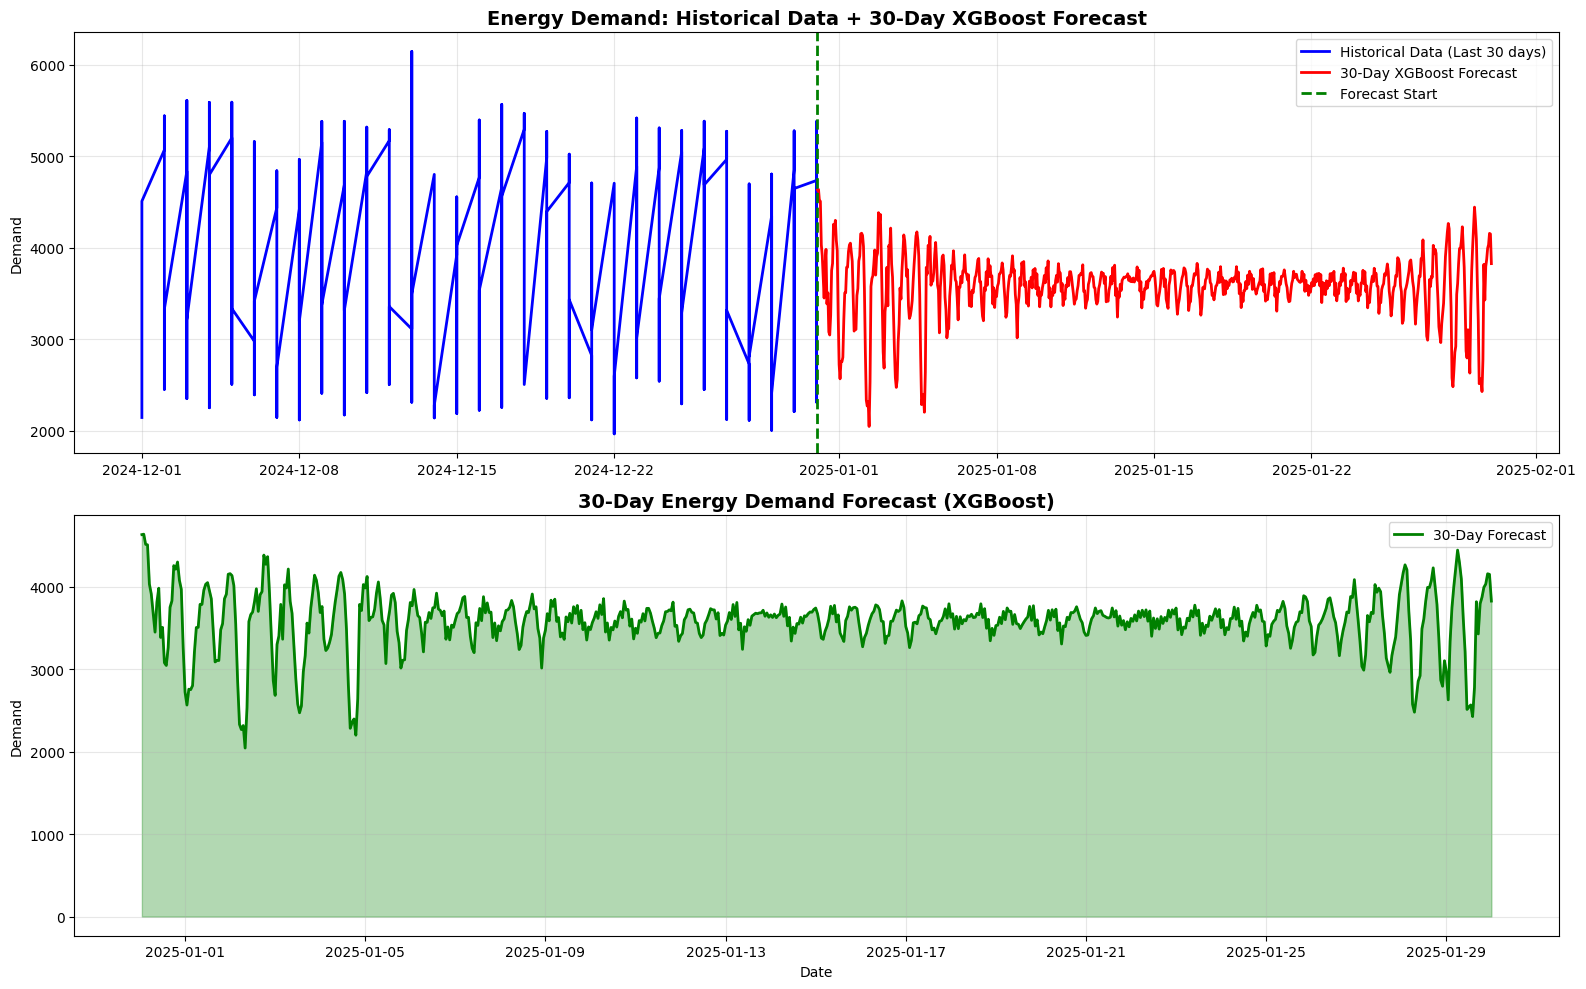

In [27]:
# ============ STEP 13: FORECAST VISUALIZATION ============
print("\n--- CREATING FORECAST VISUALIZATION ---")

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: Historical data + forecast
ax1 = axes[0]
ax1.plot(df.index[-720:], ts_data[-720:], 'b-', label='Historical Data (Last 30 days)', linewidth=2)
ax1.plot(forecast_df['Date'], forecast_df['Forecast'], 'r-', label='30-Day XGBoost Forecast', linewidth=2)
ax1.axvline(x=df.index[-1], color='g', linestyle='--', linewidth=2, label='Forecast Start')
ax1.set_title('Energy Demand: Historical Data + 30-Day XGBoost Forecast', fontsize=14, fontweight='bold')
ax1.set_ylabel('Demand')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Only forecast
ax2 = axes[1]
ax2.plot(forecast_df['Date'], forecast_df['Forecast'], 'g-', linewidth=2, label='30-Day Forecast')
ax2.fill_between(forecast_df['Date'], forecast_df['Forecast'], alpha=0.3, color='green')
ax2.set_title('30-Day Energy Demand Forecast (XGBoost)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Demand')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('xgb_forecast_30days.png', dpi=300)
print("✓ Forecast visualization saved as 'xgb_forecast_30days.png'")
plt.show()


In [28]:
# ============ STEP 14: DAILY AGGREGATES ============
print("\n--- DAILY FORECAST SUMMARY ---")

forecast_df['Day'] = forecast_df['Date'].dt.date
daily_forecast = forecast_df.groupby('Day').agg({
    'Forecast': ['mean', 'min', 'max', 'sum', 'std']
}).round(2)

daily_forecast.columns = ['Mean_Demand', 'Min_Demand', 'Max_Demand', 'Total_Demand', 'Std_Demand']

print("\nDaily Forecast Summary (First 10 days):")
print(daily_forecast.head(10))

print("\nDaily Forecast Summary (Last 5 days):")
print(daily_forecast.tail(5))

# Save daily summary
daily_forecast.to_csv('energy_forecast_daily_summary_xgboost.csv')
print("\n✓ Daily summary saved to 'energy_forecast_daily_summary_xgboost.csv'")


--- DAILY FORECAST SUMMARY ---

Daily Forecast Summary (First 10 days):
            Mean_Demand  Min_Demand  Max_Demand  Total_Demand  Std_Demand
Day                                                                      
2024-12-31      3873.89     3045.16     4637.13      89099.47      485.22
2025-01-01      3456.25     2565.30     4151.22      82949.93      493.64
2025-01-02      3485.81     2044.06     4383.62      83659.42      733.12
2025-01-03      3457.71     2471.61     4214.57      82985.14      540.83
2025-01-04      3393.38     2200.00     4173.00      81441.23      626.47
2025-01-05      3613.23     3013.75     4124.01      86717.43      315.31
2025-01-06      3633.16     3210.21     3966.49      87195.93      178.47
2025-01-07      3607.02     3200.91     3882.15      86568.48      186.56
2025-01-08      3580.47     3013.84     3911.28      85931.32      213.70
2025-01-09      3600.23     3353.44     3848.96      86405.63      141.76

Daily Forecast Summary (Last 5 days):



--- RESIDUALS ANALYSIS ---

Residuals Statistics:
  Mean: 20.5516
  Std Dev: 605.0673
  Min: -3019.9863
  Max: 4307.9361

✓ Residuals analysis plot saved as 'xgb_residuals_analysis.png'


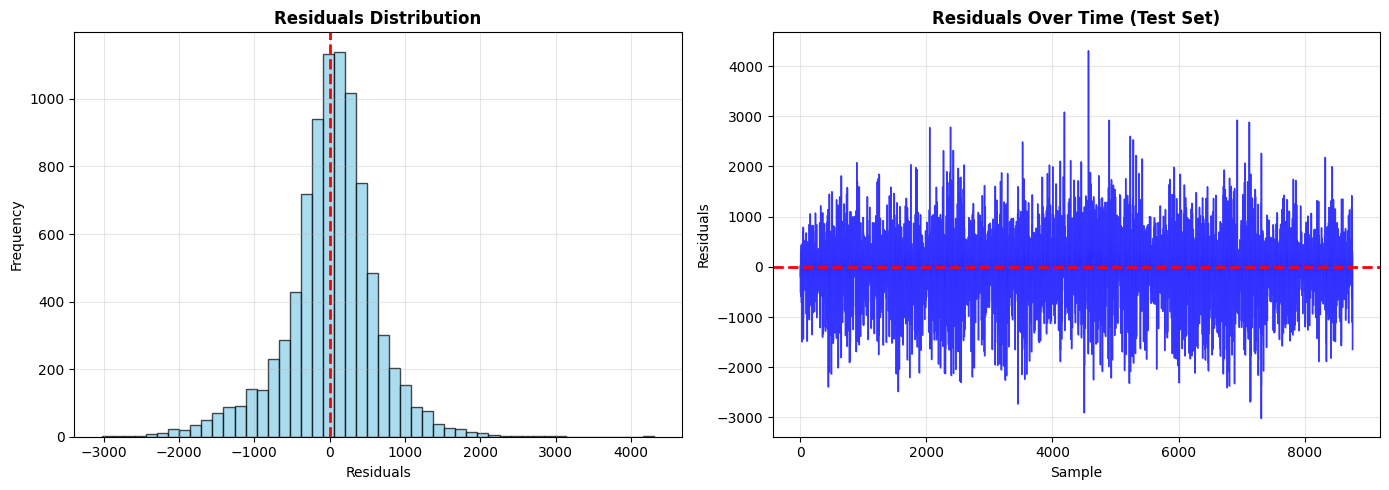

In [30]:
# ============ STEP 15: RESIDUALS ANALYSIS ============
print("\n--- RESIDUALS ANALYSIS ---")

residuals = y_test_actual - y_test_pred
residuals_mean = np.mean(residuals)
residuals_std = np.std(residuals)

print(f"\nResiduals Statistics:")
print(f"  Mean: {residuals_mean:.4f}")
print(f"  Std Dev: {residuals_std:.4f}")
print(f"  Min: {residuals.min():.4f}")
print(f"  Max: {residuals.max():.4f}")

# Plot residuals
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residuals histogram
ax1 = axes[0]
ax1.hist(residuals, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
ax1.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax1.set_title('Residuals Distribution', fontsize=12, fontweight='bold')
ax1.set_xlabel('Residuals')
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.3)

# Residuals over time
ax2 = axes[1]
ax2.plot(residuals, 'b-', linewidth=1, alpha=0.7)
ax2.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax2.fill_between(range(len(residuals)), residuals, 0, alpha=0.3, color='blue')
ax2.set_title('Residuals Over Time (Test Set)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Sample')
ax2.set_ylabel('Residuals')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('xgb_residuals_analysis.png', dpi=300)
print("\n✓ Residuals analysis plot saved as 'xgb_residuals_analysis.png'")
plt.show()

In [31]:
# ============ STEP 16: SUMMARY REPORT ============
print("\n" + "="*70)
print("XGBOOST FORECAST SUMMARY - NEXT 30 DAYS")
print("="*70)
print(f"\nModel Configuration:")
print(f"  Algorithm: XGBoost Regressor")
print(f"  Lookback window: {lookback} hours")
print(f"  Total features: {X.shape[1]}")
print(f"  Max depth: 6")
print(f"  Learning rate: 0.1")
print(f"  N estimators: 200")
print(f"  Total Parameters: {xgb_model.n_estimators}")

print(f"\nTraining Performance:")
print(f"  Training RMSE: {train_rmse:.4f}")
print(f"  Training MAE: {train_mae:.4f}")
print(f"  Training MAPE: {train_mape:.4f}%")
print(f"  Training R²: {train_r2:.4f}")

print(f"\nTesting Performance:")
print(f"  Testing RMSE: {test_rmse:.4f}")
print(f"  Testing MAE: {test_mae:.4f}")
print(f"  Testing MAPE: {test_mape:.4f}%")
print(f"  Testing R²: {test_r2:.4f}")

print(f"\n30-Day Forecast Statistics:")
print(f"  Average Daily Demand: {daily_forecast['Mean_Demand'].mean():.2f}")
print(f"  Total 30-Day Demand: {daily_forecast['Total_Demand'].sum():.2f}")
print(f"  Forecast Range: {forecast_predictions_original.min():.2f} - {forecast_predictions_original.max():.2f}")
print(f"  Average Daily Std Dev: {daily_forecast['Std_Demand'].mean():.2f}")

print("\n" + "="*70)
print("✓ XGBoost 30-Day Forecast Completed Successfully!")
print("="*70)
print("\nGenerated Files:")
print("  1. energy_forecast_30days_xgboost.csv - Hourly predictions")
print("  2. energy_forecast_daily_summary_xgboost.csv - Daily aggregates")
print("  3. xgb_forecast_30days.png - Forecast visualization")
print("  4. xgb_actual_vs_predicted.png - Model predictions comparison")
print("  5. xgb_feature_importance.png - Feature importance plot")
print("  6. xgb_residuals_analysis.png - Residuals analysis")
print("  7. xgb_time_series_plot.png - Original time series")


XGBOOST FORECAST SUMMARY - NEXT 30 DAYS

Model Configuration:
  Algorithm: XGBoost Regressor
  Lookback window: 24 hours
  Total features: 29
  Max depth: 6
  Learning rate: 0.1
  N estimators: 200
  Total Parameters: 200

Training Performance:
  Training RMSE: 454.9946
  Training MAE: 333.1678
  Training MAPE: 0.0758%
  Training R²: 0.8960

Testing Performance:
  Testing RMSE: 605.4162
  Testing MAE: 437.1652
  Testing MAPE: 0.0952%
  Testing R²: 0.8165

30-Day Forecast Statistics:
  Average Daily Demand: 3587.76
  Total 30-Day Demand: 2577422.24
  Forecast Range: 2044.06 - 4637.13
  Average Daily Std Dev: 255.59

✓ XGBoost 30-Day Forecast Completed Successfully!

Generated Files:
  1. energy_forecast_30days_xgboost.csv - Hourly predictions
  2. energy_forecast_daily_summary_xgboost.csv - Daily aggregates
  3. xgb_forecast_30days.png - Forecast visualization
  4. xgb_actual_vs_predicted.png - Model predictions comparison
  5. xgb_feature_importance.png - Feature importance plot
  6. 

In [33]:
# ============ STEP 17: SAVE MODEL ============
print("\n--- SAVING MODEL ---")
xgb_model.save_model('xgboost_energy_model.json')
print("✓ Model saved as 'xgboost_energy_model.json'")
print("\nTo load model later:")
print("  import xgboost as xgb")
print("  model = xgb.XGBRegressor()")
print("  model.load_model('xgboost_energy_model.json')")


--- SAVING MODEL ---
✓ Model saved as 'xgboost_energy_model.json'

To load model later:
  import xgboost as xgb
  model = xgb.XGBRegressor()
  model.load_model('xgboost_energy_model.json')


In [35]:
import pickle

In [36]:
# 3. Standard Python Serialization (Pickle)
model_path_pickle = 'forcast_xgb_model_pickle.pkl'
# Note: While common, Joblib is often better for large NumPy-heavy models like XGBoost.
with open(model_path_pickle, 'wb') as f:
    pickle.dump(xgb_model, f)
print(f"Model systematically saved to: {model_path_pickle}")

Model systematically saved to: forcast_xgb_model_pickle.pkl
